In [28]:
#import packages
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from datetime import date 
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
! pip install regressors
from regressors import stats

import duckdb, sqlalchemy

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=0ec1d917e754d251cfaa8bee28c0d6af5ed8ffd2103314ea0b58cb95391ded5f
  Stored in directory: /Users/serenautech/Library/Caches/pip/wheels/46/c3/e9/d1797db3a01a1f101ad3cbcdf01b1be7273a25c78c77dd4bb9
Successfully built regressors
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Introduction
This analysis aims to investigate weather phenomena in Ithaca and surrounding cities. For this study Ithaca was chosen as the central location, and then one city North, South, East, and West of Ithaca is chosen to include 5 cities total. This study is intended to be mainly applicable to a Northeastern climate, and focuses on statistically significant differences between the selected areas and building a model to predict temperatures. It is found that only for certain seasons is weather significantly different 100 miles away from Ithaca. It is also found that only in certain regions is there more likely to be precipitation the day after a trace of precipitation is detected. It is also found that a linear regression model predicting temperature based on lattitude, longitude, month, and day is not an accurate way to model weather.

#### Research Questions

1. Is there a significant difference between weather trends when moving about 100 miles away from a central location?
2. Do trace amount of precipitation indicate that the next day is more likely to experience percipitation? Does this depend on season or region?
3. Is it possible to accurately model and predict the weather based on another location’s weather?
4. Does latitude, longitude, or elevation have the most significant impact on temperature? On precipitation?




## Data Cleaning



We obtained our data through 3 data requests to weather.gov. First, we requested Ithaca's data, and then we decided to expand out analysis to include locations north, east, south, and west of Ithaca. Our second data pull included the following cities: Watertown (North), Bloomsburg (South), Cobleskill (East), and Avoca (West). Avoca did not contain any temperature data, so we decided to request data for Erie as a replacement. The cell below, reads in the csv files obtained from weather.gov.

In [2]:
#read in csvs
ithaca = pd.read_csv("Ithaca.csv")
others = pd.read_csv("AdjacentCities.csv")
west = pd.read_csv("Erie.csv")
#print(ithaca.head())
#print(west.head())
others = others.dropna(axis=0,subset=['STATION'])
#print(others.head())

/Users/serenautech/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9,15,17,19,21,27,29,31,33,35,37,39,41,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/serenautech/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (27,29,31,33,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/serenautech/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7,9,11,13,15,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Since certain locations contained multiple weather stations, we created the column Location to group the entries as shown in the cell below.

In [3]:
#Add column to indicate location (relative to ithaca)
ithaca["Location"] = "Central"
west['Location'] = "West"
#print(others['NAME'].unique())
locations = []
for i in others['NAME']:
    if "WATERTOWN" in i:
        locations.append('North')
    elif "BLACK RIVER" in i:
        locations.append("North")
    elif "ESPY" in i:
        locations.append("South")
    elif "BLOOMSBURG" in i:
        locations.append("South")
    elif "COBLESKILL" in i:
        locations.append("East")
    else:
        locations.append('N/A')
others['Location'] = locations
print(others['Location'].unique())


['North' 'N/A' 'South' 'East']


Certain cities had more data attributes available than others, so to maintain cohesion, the cell below identifies common columns between the three data sets. We then dropped any uncommon columns and concatenated the three datasets to form one dataframe containing all relevant data.

In [4]:
#Check all columns match before concatenation
columns_to_keep = []

for i in ithaca.columns.tolist():
    if (i in others.columns.tolist()) & (i in west.columns.tolist()) :
        columns_to_keep.append(i)
ithaca_good = ithaca[columns_to_keep]
others_good = others[columns_to_keep]
west_good = west[columns_to_keep]
        
if (ithaca_good.columns.tolist() == others_good.columns.tolist()) & (ithaca_good.columns.tolist() == west_good.columns.tolist()):
    print("Columns match: proceed")
    final_df = pd.concat([ithaca_good,others_good,west_good])
else:
    print(ithaca.columns)
    print(others.columns)
    
#print(final_df)

Columns match: proceed


In the cell below, we checked to make sure that none of the columns contained only null values. All columns contained at least one relevant datapoint, but if this was not the case, we also included code that would drop an entirely null column.

In [5]:
#Check for null values in columns
print(final_df.columns)
#If a column has only null values, drop the column
null_cols = []
for c in final_df.columns:
    if final_df[c].isnull().all():
        null_cols.append(c)
if len(null_cols) == 0:
    print("No null columns")
else:
    print('Null columns:', null_cols)
    final_df = final_df.drop(null_cols)

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DAPR',
       'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES',
       'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX',
       'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WESF', 'WESF_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'Location'],
      dtype='object')
No null columns


The attributes columns in the weather.gov data contains a string that contains multiple attribute indicators concatenated together. "Trace" is an attribute that we believe will be relevant to our analysis and is represented by a "T" in the attribute columns. We used this to create new binary columns that indicate whether or not there was a trace of precipitation or snow on a given day.

In [6]:
#Create binary columns to indicate if there was trace of precipitation for snow and rain
precip_binary = []
snow_binary = []
for p in final_df['PRCP_ATTRIBUTES']:
    #print(type(p))
    if (type(p) == str):
        if 'T' in p:
            precip_binary.append(1)
        else:
            precip_binary.append(0)
    else:
        precip_binary.append(0)
        
for s in final_df['SNOW_ATTRIBUTES']:
    if (type(s) == str):
        if 'T' in s:
            snow_binary.append(1)
        else:
            snow_binary.append(0)
    else:
        snow_binary.append(0)
    
final_df['PrecipTrace'] = precip_binary
final_df['SnowTrace'] = snow_binary

With the addition of the binary columns, we no longer need the initial attributes columns and drop them from the dataframe below.

In [7]:
#Drop attributes columns now that we have created the binary columns
final_df = final_df.drop(columns = ['PRCP_ATTRIBUTES', 'SNOW_ATTRIBUTES'])

In addition, we converted the data column to datetime.

In [8]:
#Convert date column to datetime
final_df['DATE'] = pd.to_datetime(final_df['DATE'], format = '%m/%d/%Y')
#print(final_df['DATE'])

We also created a column that indicates the season. We categorized seasons as:

Winter: December-February

Spring: March-May

Summer: June-August

Fall: September-November

In [9]:
season_list = []
for i in final_df['DATE']:
    if (i.month == 12) or (i.month == 1) or (i.month == 2):
        season_list.append('Winter')
    elif (i.month == 3) or (i.month == 4) or (i.month == 5):
        season_list.append('Spring')
    elif (i.month == 6) or (i.month == 7) or (i.month == 8):
        season_list.append('Summer')
    elif (i.month == 9) or (i.month == 10) or (i.month == 11):
        season_list.append('Fall')
    else:
        print("ERROR")
final_df['Season'] = season_list

In some cases, there were multiple stations within the same location category that recorded data. To account for this, we created an aggregated dataframe that groups by location and date and takes the average of the temperature, location, elevation, and precipitation data. This aggregated dataframe takes the maximum of the binary columns to indicate if there was a trace anywhere within the location. We wanted to maintain the binary property of the columns in order to perform logistic regression in the final phase of the project.

In [38]:
#Aggregate dataframe to account for locations with multiple stations taking recordings on the same day
%sql agg_df << select DATE, Location, avg(LATITUDE) as Latitude, avg(LONGITUDE) as Longitude, avg(ELEVATION) as Elevation, AVG(TMAX) as MaxTemp, AVG(TMIN) as MinTemp,AVG(PRCP) as Precipitation, AVG(SNOW) as Snowfall, MAX(PrecipTrace) as PrecipTrace, MAX(SnowTrace) as SnowTrace, Season from final_df group by Location, DATE, Season order by DATE
agg_df['AverageTemp'] = 0.5*agg_df['MaxTemp'] + 0.5*agg_df['MinTemp']

agg_df['Month_Grouping'] = agg_df['DATE'].dt.to_period('M')
agg_df['Month_Grouping'] = agg_df['Month_Grouping'].astype('datetime64[M]')
#print(agg_df[['DATE','Month Grouping']])

Returning data to local variable agg_df


We also split the aggregated dataframe into smaller dataframes based on location.

In [16]:
#Create 5 separate data frames based on location for individual analyses when needed
central = agg_df[agg_df['Location']=="Central"]
north = agg_df[agg_df['Location']=="North"]
south = agg_df[agg_df['Location']=="South"]
east = agg_df[agg_df['Location']=="East"]
west = agg_df[agg_df['Location']=="West"]

## Data Description

Each row in this dataset is a date ranging from 2000 to 2022, and location, which is either Ithaca, Bloomsburg, Erie, Watertown, or Cobleskill. The data was received in three separate files, as the National Weather Service sends one file for each request. First Ithaca data was requested to test the data quality, and understand attributes provided. Then 4 more cities were requested, and were provided in one file. However, one of these cities was missing temperature data, so we chose to request a different city, thus resulting in a third file. We then combined these files to include 5 cities with Ithaca at the center. The columns in this data set are as follows: 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DAPR',  'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES',  'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TMAX',  'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'WESF', 'WESF_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'Location', 'Precip Trace', and 'Snow Trace'.  The dataset created by combining cities has 71,144 rows and 27 columns.

This dataset was created as a record of past observable weather events, and is used to predict future events, and train models. The data comes from the National Weather Service, which is a federally funded agency, whose job is to provide weather forecasts and other weather information, including data, in the public domain. The National Weather Service uses their own remote sensing equipment as well as working with some local weather stations to collect data. Therefore, the data was directly observable through the use of weather hardware apparatuses including thermometers, rain gauges, snow boards, and yardsticks. Since these tools were used, people and surveying were not involved in this data creation. Depending on the equipment available in the chosen cities, some of the null columns may exist because the proper tools to record such an observation were not available. Meanwhile, other null values may have occurred because there was not a reliable weather station in the chosen locations at a certain time, since all the locations are relatively rural. Some of the preprocessing that occurred is data filtering to only include observations in the desired locations, and qualitative attributes for various weather conditions, such as snow or rain, being added based on corresponding columns. 


Raw data source

Ithaca data: https://drive.google.com/file/d/1nqrr9H8sJTQJVXNlwPeIdXmr4nBxcg7M/view?usp=sharing 

Other city data: https://drive.google.com/file/d/19-Uf3W-ls7k7-OtloUc4hNisYEYgmxmf/view?usp=sharing 

Erie data: https://drive.google.com/file/d/1kqY8DdBSWfDtdshsmF35hZYGRaoIHsY3/view?usp=sharing 
 


## Data Limitations

Null values: The most consistent quantitative observations available for each location and date are temperature, elevation, precipitation, and snowfall. However, there are many other columns containing other types of observations, which have a significant amount of null values. This may make it hard to incorporate these other observations if there is not enough data, and could lead to a less accurate model. At this time we are still including these other attributes in the dataset, but we recognize that they may have to be excluded later.

Different length of time frames: Five cities are included in this analysis and new dataset, however different amounts of data exist for each city. Ideally 20 years of history would be included for each city, however this was not available, so there is less data to use to train a model for certain cities, which could impact accuracy of results. 

Limited scope of cities: Only a total of 5 cities are included in this dataset, so conclusions from this analysis are not necessarily applicable to other areas. This is especially true because this dataset is centered around Ithaca, which is a Northeastern climate, however in a desert setting the results to these research questions likely will not be applicable based on this analysis.

Attributes are not very descriptive: The attributes for different weather events are not very descriptive. This could make it difficult to incorporate the attribute columns into an analysis as it is unclear what some of the different attributes mean, especially in the context of the research questions.

Missing temperature data: For Bloomsburg, which is the city South of Ithaca chosen, temperature data is missing for many years. This is an issue because temperature is one of the most consistent columns in other cities, so it is critical to analysis. However, there are not many major cities in the radius since Ithaca is in a relatively rural setting, so finding another city with better data may not be possible. This will make predictions over time difficult when including Bloomsburg, and we may have to limit the scope to timeframes with complete data.


## Preregistration Statement

Hypothesis 1: The average temperature is significantly different between regions for each season.

Hypothesis 2: There is a higher likelihood of a trace of precipitation if the following or previous day recorded precipitation greater than 0.


## Data Analysis

For the first stage of our exploratory data analysis, we printed the summary statistics for the dataframe containing all the regions and the summary statistics for each region individually. Overall, the statistics appear similar across the regions. The Southern region appears to be slightly warmer compared to the rest, and the snowfall is highest in the North. In the following sections, we plan on exploring further into seasonality and how it affects the summary statistics and trends.

In [17]:
#Summary statistics for each region
agg_list = [central, north, south, east, west]
title_list = ['Central', 'North', 'South', 'East','West']
print('All Regions')
print(round(agg_df[['MaxTemp','MinTemp','Precipitation','Snowfall','AverageTemp']].describe(),3))
print()
for i in range(0,5,1):
    print(title_list[i])
    print(round(agg_list[i][['MaxTemp','MinTemp','Precipitation','Snowfall','AverageTemp']].describe(),3))
    print()

All Regions
         MaxTemp    MinTemp  Precipitation   Snowfall  AverageTemp
count  34006.000  33645.000      37180.000  34406.000    33599.000
mean      57.259     38.860          0.121      0.235       48.044
std       20.271     18.931          0.271      1.062       19.226
min      -10.000    -44.000          0.000      0.000      -19.500
25%       40.000     26.000          0.000      0.000       33.500
50%       59.000     39.000          0.000      0.000       49.000
75%       75.000     55.000          0.113      0.000       64.500
max       98.000     80.000          5.270     25.000       88.000

Central
        MaxTemp   MinTemp  Precipitation  Snowfall  AverageTemp
count  8265.000  8265.000       8281.000  8290.000     8265.000
mean     57.118    37.478          0.111     0.181       47.298
std      20.336    18.008          0.259     0.787       18.801
min       0.000   -22.000          0.000     0.000      -10.000
25%      40.000    25.000          0.000     0.000      

The cell below produces 5 subplots of daily average temperature throughout 2017. We chose 2017 as it was the most recent year in which all regions had a substantial amount of temperature data. Our Southern region is missing a couple periods of temperature data within 2017, most notably in June. As expected, there is clear seasonality for each region.

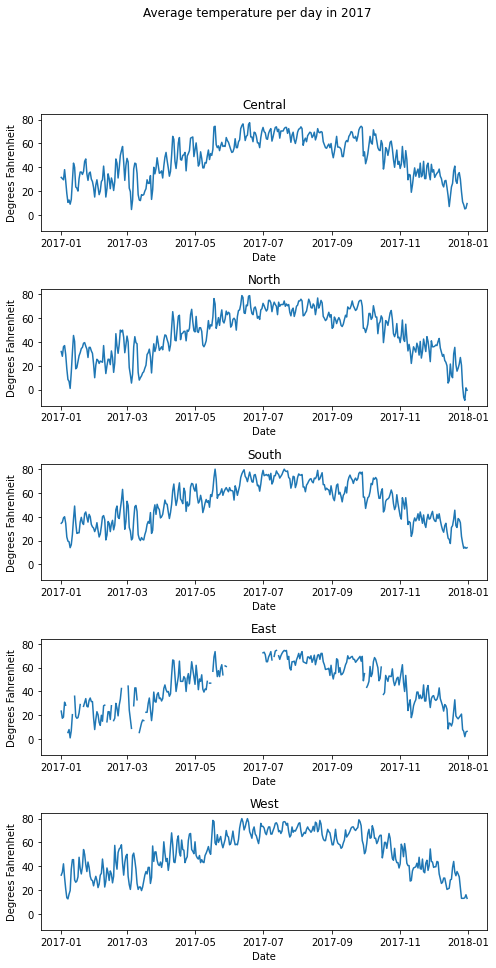

In [141]:
#temperature for sample year 2017
central_2017 = central[(central['DATE']>='2017-01-01')&(central['DATE']<= '2017-12-31')]
north_2017 = north[(north['DATE']>='2017-01-01')&(north['DATE']<= '2017-12-31')]
south_2017 = south[(south['DATE']>='2017-01-01')&(south['DATE']<= '2017-12-31')]
east_2017 = east[(east['DATE']>='2017-01-01')&(east['DATE']<= '2017-12-31')]
west_2017 = west[(west['DATE']>='2017-01-01')&(west['DATE']<= '2017-12-31')]

df_list = [central_2017, north_2017, south_2017, east_2017, west_2017]
fig, axs = plt.subplots(5, sharex = False, sharey=True, figsize = (8,15))
fig.suptitle('Average temperature per day in 2017')
fig.subplots_adjust(hspace = 0.5)
index = 0
title_list = ['Central', 'North', 'South', 'East','West']
for i in df_list:
    axs[index].plot(i['DATE'], i['AverageTemp'])
    axs[index].set_ylabel('Degrees Fahrenheit')
    axs[index].set_xlabel('Date')
    axs[index].set_title(title_list[index])
    index+=1

The code below creates a lineplot to compare average monthly temperature across the regions. It is incredibly difficult to distinguish between the regions which once again suggests the importance of breaking up the data by seasonality in future phases.

Returning data to local variable month_df


[Text(0.5, 1.0, 'Average Temperature by Month')]

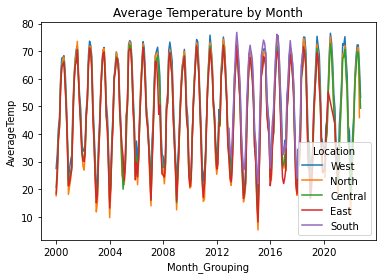

In [142]:
#line plot of temparature in each region over time
%sql month_df << select Month_Grouping, avg(AverageTemp) as AverageTemp, Location from agg_df group by Month_Grouping, Location order by Month_Grouping
sns.lineplot(x='Month_Grouping', y='AverageTemp', hue = 'Location', data = month_df).set(title = 'Average Temperature by Month')

The graph below shows a lineplot of total average annual rainfall across each of the regions. It is important to note that the Southern region did not begin collecting rainfall data until the end of 2011. It also appears that the Eastern region stopped collecting rainfall data in 2021.

Returning data to local variable precip_df


[Text(0.5, 1.0, 'Total Rainfall by Year in Inches')]

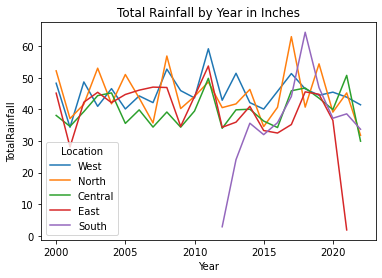

In [143]:
#Comparison of annual rainfall 
agg_df['Year'] = agg_df['DATE'].dt.year
%sql precip_df << select Year, Location, sum(Precipitation) as TotalRainfall, sum(Snowfall) as TotalSnowfall from agg_df group by Year, Location order by Year
precip_df['TotalPrecipitation'] = precip_df['TotalRainfall'] + precip_df['TotalSnowfall']
sns.lineplot(x='Year', y='TotalRainfall', hue = 'Location', data = precip_df).set(title = 'Total Rainfall by Year in Inches')

The graph below shows a lineplot of total average annual snowfall across each of the regions. Once again, the Southern region did not begin collecting snowfall data until the end of 2011, and it seems that the Eastern region stopped collecting data in 2021. In this plot, the Northern and Western region seem to have considerably higher snowfall levels compared to the other regions.

[Text(0.5, 1.0, 'Total Snowfall by Year in Inches')]

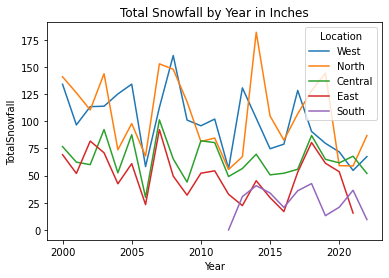

In [144]:
#Comparison of annual snowfall
sns.lineplot(x='Year', y='TotalSnowfall', hue = 'Location', data = precip_df).set(title = 'Total Snowfall by Year in Inches')

The plot below shows total annual precipitation across each region. The Northern and Western have the highest precipitation levels as expected due to the snowfall plot.

[Text(0.5, 1.0, 'Total Precipitation by Year in Inches')]

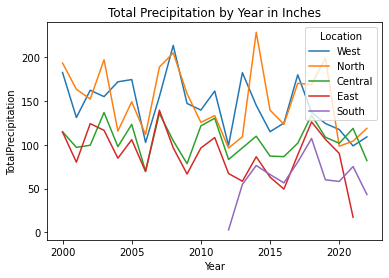

In [145]:
#Comparison of annual precipitation
sns.lineplot(x='Year', y='TotalPrecipitation', hue = 'Location', data = precip_df).set(title = 'Total Precipitation by Year in Inches')

Finally, we ran some summary statistics on the Trace columns for each region since we plan to conduct a logistic regression with these variables in the following phase. It is interesting to note that the Eastern region has a high number of trace observations despite having one of the lowest annual precipitation totals. 

In [146]:
#Summary statistics for trace observations
for i in range(0,5,1):
    print(title_list[i])
    temp_df = round(agg_list[i][['PrecipTrace', 'SnowTrace']].describe(),3)
    print(temp_df.head(3))
    print()

Central
       PrecipTrace  SnowTrace
count     8290.000   8290.000
mean         0.162      0.100
std          0.368      0.299

North
       PrecipTrace  SnowTrace
count     8244.000   8244.000
mean         0.085      0.061
std          0.279      0.240

South
       PrecipTrace  SnowTrace
count     2502.000   2502.000
mean         0.060      0.039
std          0.238      0.193

East
       PrecipTrace  SnowTrace
count     7533.000   7533.000
mean         0.098      0.089
std          0.297      0.284

West
       PrecipTrace  SnowTrace
count     8325.000   8325.000
mean         0.225      0.112
std          0.418      0.315



## Hypothesis 1: The average temperature is significantly different between the regions and Ithaca for each season.

In [18]:
# Winter
central_w = central[central['Season']=="Winter"]
north_w = north[north['Season']=="Winter"]
south_w = south[south['Season']=="Winter"]
east_w = east[east['Season']=="Winter"]
west_w = west[west['Season']=="Winter"]

regions = ["North", "South", "East", "West"]
dfs_w = [north_w, south_w, east_w, west_w]
for df in range(0,4):
    ttest = stats.ttest_ind(central_w['AverageTemp'].tolist(), dfs_w[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 1.9558416816944027e-13

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 8.096448424092776e-28

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 1.8077452242062063e-05

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Winter at the 5% significance level.
The p value is: 1.305464973143051e-34



In [148]:
# Spring
central_sp = central[central['Season']=="Spring"]
north_sp = north[north['Season']=="Spring"]
south_sp = south[south['Season']=="Spring"]
east_sp = east[east['Season']=="Spring"]
west_sp = west[west['Season']=="Spring"]

regions = ["North", "South", "East", "West"]
dfs_sp = [north_sp, south_sp, east_sp, west_sp]
for df in range(0,4):
    ttest = stats.ttest_ind(central_sp['AverageTemp'].tolist(), dfs_sp[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North does not have an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 0.9652717834421743

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 1.351690141145119e-12

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 0.03583469843315028

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Spring at the 5% significance level.
The p value is: 9.24059447928492e-13



In [149]:
# Summer
central_su = central[central['Season']=="Summer"]
north_su = north[north['Season']=="Summer"]
south_su = south[south['Season']=="Summer"]
east_su = east[east['Season']=="Summer"]
west_su = west[west['Season']=="Summer"]

regions = ["North", "South", "East", "West"]
dfs_su = [north_su, south_su, east_su, west_su]
for df in range(0,4):
    ttest = stats.ttest_ind(central_su['AverageTemp'].tolist(), dfs_su[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 3.304918245315349e-15

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 9.305792989687287e-42

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 0.025067628655651365

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Summer at the 5% significance level.
The p value is: 1.4592374845902133e-55



In [150]:
# Fall
central_f = central[central['Season']=="Fall"]
north_f = north[north['Season']=="Fall"]
south_f = south[south['Season']=="Fall"]
east_f = east[east['Season']=="Fall"]
west_f = west[west['Season']=="Fall"]

regions = ["North", "South", "East", "West"]
dfs_f = [north_f, south_f, east_f, west_f]
for df in range(0,4):
    ttest = stats.ttest_ind(central_f['AverageTemp'].tolist(), dfs_f[df]['AverageTemp'].tolist(), nan_policy = 'omit')
    if ttest[1] < 0.05:
        print("The region", regions[df], "has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()
    if ttest[1] >= 0.05:
        print("The region", regions[df], "does not have an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.")
        print("The p value is:", ttest[1])
        print()

The region North does not have an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 0.8142480696187714

The region South has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 1.6853098145250532e-13

The region East has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 8.941605995834669e-05

The region West has an average temperature that is significantly different than Ithaca's average temperature during the Fall at the 5% significance level.
The p value is: 7.40585601328914e-29



# Hypothesis 2: There is a higher likelihood of precipitation greater than 0 if the previous day recorded precipitation trace.

In [32]:
regions_precip = ['Central', 'North', 'South', 'East', 'West']
dfs_precip = [central, north, south, east, west]
trace_counts = []

#Initialize list for counts of precipitation days where the day before was a trace day
prec_trace_counts = []
no_prec_trace_counts = []
back_to_back_days = []
yes_prec_no_trace =[]

for df in dfs_precip:
    #Calculate probabiltiy of  precip trace for each region within back to back days
    df=df.reset_index()
    trace_count = 0
    #Calculate number of back to back days in the dataframe as well as counts of instances where there
    count_prec_and_trace = 0
    count_trac_no_prec = 0
    count_day_pairs = 0
    count_prec = 0
    count_prec_no_trace = 0
    for i in df.index:
        today = df['DATE'][i]
        if (i+1) in df.index:
            if (today + timedelta(days=1)) == df['DATE'][i+1]:
                count_day_pairs +=1
                if (df['PrecipTrace'][i]>0):
                    trace_count +=1
                if (df['PrecipTrace'][i] == 1) and (df['Precipitation'][i+1]>0):
                    count_prec_and_trace+=1
                if (df['PrecipTrace'][i] == 1) and (df['Precipitation'][i+1]==0):
                    count_trac_no_prec += 1
                if (df['PrecipTrace'][i] != 1) and (df['Precipitation'][i]>0):
                    count_prec_no_trace += 1
    prec_trace_counts.append(count_prec_and_trace)
    no_prec_trace_counts.append(count_trac_no_prec)
    back_to_back_days.append(count_day_pairs)
    trace_counts.append(trace_count)
    yes_prec_no_trace.append(count_prec_no_trace)


In [152]:
for i in range(0,5):
    print('The probability of precipitation trace in ', regions_precip[i], ' is ', round((trace_counts[i]/back_to_back_days[i]),4))
    print('The probability of preciptitation after trace in ', regions_precip[i], ' is ', round((prec_trace_counts[i]/trace_counts[i]),4))
    print('The probability of no preciptitation after trace in ', regions_precip[i], ' is ', round((no_prec_trace_counts[i]/trace_counts[i]),4))
    print()

The probability of precipitation trace in  Central  is  0.1617
The probability of preciptitation after trace in  Central  is  0.5261
The probability of no preciptitation after trace in  Central  is  0.4739

The probability of precipitation trace in  North  is  0.0848
The probability of preciptitation after trace in  North  is  0.5136
The probability of no preciptitation after trace in  North  is  0.4864

The probability of precipitation trace in  South  is  0.0602
The probability of preciptitation after trace in  South  is  0.391
The probability of no preciptitation after trace in  South  is  0.609

The probability of precipitation trace in  East  is  0.0979
The probability of preciptitation after trace in  East  is  0.3352
The probability of no preciptitation after trace in  East  is  0.6648

The probability of precipitation trace in  West  is  0.2254
The probability of preciptitation after trace in  West  is  0.5991
The probability of no preciptitation after trace in  West  is  0.400

In [39]:
# day after trace, vs not day after trace
#null hypothesis: p1=p2
#alternative hypothesis p2<p1
for i in range(0,5):
    num_day_after_trace_day = trace_counts[i]
    num_not_after_trace_day = len(df.index) - num_day_after_trace_day
    trace_and_precip = prec_trace_counts[i]
    not_trace_and_precip = yes_prec_no_trace[i]
    p = (trace_and_precip+not_trace_and_precip)/(len(df.index))
    p1 = trace_and_precip/num_day_after_trace_day
    p2 = not_trace_and_precip/num_not_after_trace_day
    Z = (p2-p1)/np.sqrt(p*(1-p)*((1/num_day_after_trace_day)+(1/num_not_after_trace_day)))
    print('Z score for', regions_precip[i], ' is ', Z)
    if (Z <= -1.645): 
        print('The difference between precipitation for the day after trace and days not after trace is not significant for',
             regions_precip[i])
    print()
        
    


Z score for Central  is  2.4062940661134022

Z score for North  is  0.26135639843110003

Z score for South  is  -9.35498593578702
The difference between precipitation for the day after trace and days not after trace is not significant for South

Z score for East  is  2.4893312749142242

Z score for West  is  0.9458881750869284



## Hypothesis 3: We can create a model that accurately predicts temperature based on longitude, latitude, and time of year.

In [21]:
def run_regression(var_lst, train, test, pred_var):
    X=train[var_lst]
    model = LinearRegression().fit(X, train[pred_var])
    train_pred = model.predict(X) 
    test_pred = model.predict(test[var_lst])
    mse_train = mean_squared_error(train[pred_var],train_pred)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(test[pred_var],test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(train[pred_var],train_pred)
    mae_test = mean_absolute_error(test[pred_var],test_pred)
    print(var_lst)
    print('Intercept: ', model.intercept_)
    print('Coefficient:', model.coef_)
    print('Train RMSE: ', mse_train)
    print('Test RMSE: ', mse_test)
    print('Train MAE: ', mae_train)
    print('Test MAE: ', mae_test)
    return model

In [22]:
#Convert DATE column to month and day integers for use in multiple regression
day_int = []
month_int = []
for i in agg_df['DATE']:
    day_int.append(int(i.strftime("%d")))
    month_int.append(int(i.strftime("%m")))
agg_df['Day'] = day_int
agg_df['Month'] = month_int

In [23]:
#drop nans from agg df for important columns 
agg_df = agg_df.dropna(subset=['Longitude', 'Latitude', 'Month', 'Day', 'AverageTemp'])
X_train, X_test = train_test_split(agg_df, test_size= 0.1)
variables = ['Longitude', 'Latitude', 'Month', 'Day']
temp_model = run_regression(variables, X_train, X_test, 'AverageTemp')

['Longitude', 'Latitude', 'Month', 'Day']
Intercept:  15.490955910931554
Coefficient: [-0.74949978 -0.83774689  1.61406436  0.0167729 ]
Train RMSE:  334.83691416632934
Test RMSE:  326.67040656228687
Train MAE:  15.57783793421845
Test MAE:  15.233912038055694


In [31]:
print(stats.summary(temp_model, X_train[variables], X_train['AverageTemp'], variables))

Residuals:
     Min      1Q  Median      3Q      Max
-38.5307 -15.716  -0.937  14.257  64.3583


Coefficients:
             Estimate  Std. Error  t value  p value
_intercept  15.490956    8.923235   1.7360  0.08257
Longitude   -0.749500    0.018706 -40.0682  0.00000
Latitude    -0.837747    0.058202 -14.3938  0.00000
Month        1.614064    0.030422  53.0554  0.00000
Day          0.016773    0.011803   1.4211  0.15531
---
R-squared:  0.09376,    Adjusted R-squared:  0.09364
F-statistic: 782.00 on 4 features
None


In [189]:
#Add column for predicted average temp
agg_df['PredictedTemp'] = temp_model.intercept_ + temp_model.coef_[0]*agg_df['Longitude']+temp_model.coef_[1]*agg_df['Latitude']+temp_model.coef_[2]*agg_df['Month']+temp_model.coef_[3]*agg_df['Day']

Replot 2017 temperature data vs. model predictions

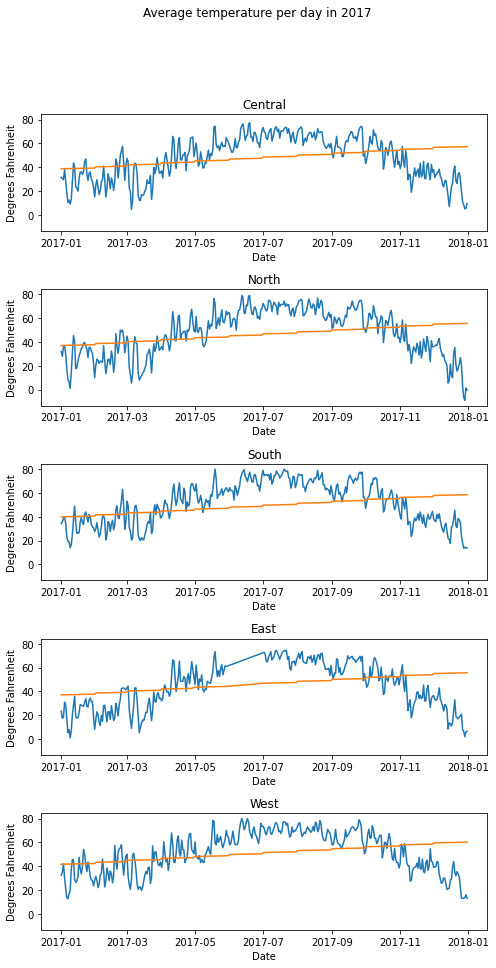

In [190]:
#recreate region dfs
central = agg_df[agg_df['Location']=="Central"]
north = agg_df[agg_df['Location']=="North"]
south = agg_df[agg_df['Location']=="South"]
east = agg_df[agg_df['Location']=="East"]
west = agg_df[agg_df['Location']=="West"]

#temperature for sample year 2017
central_2017 = central[(central['DATE']>='2017-01-01')&(central['DATE']<= '2017-12-31')]
north_2017 = north[(north['DATE']>='2017-01-01')&(north['DATE']<= '2017-12-31')]
south_2017 = south[(south['DATE']>='2017-01-01')&(south['DATE']<= '2017-12-31')]
east_2017 = east[(east['DATE']>='2017-01-01')&(east['DATE']<= '2017-12-31')]
west_2017 = west[(west['DATE']>='2017-01-01')&(west['DATE']<= '2017-12-31')]

df_list = [central_2017, north_2017, south_2017, east_2017, west_2017]
fig, axs = plt.subplots(5, sharex = False, sharey=True, figsize = (8,15))
fig.suptitle('Average temperature per day in 2017')
fig.subplots_adjust(hspace = 0.5)
index = 0
title_list = ['Central', 'North', 'South', 'East','West']
for i in df_list:
    axs[index].plot(i['DATE'], i['AverageTemp'])
    axs[index].plot(i['DATE'], i['PredictedTemp'])
    axs[index].set_ylabel('Degrees Fahrenheit')
    axs[index].set_xlabel('Date')
    axs[index].set_title(title_list[index])
    index+=1

## Evaluation of Significance
Hypothesis 1: During winter the temperature for each region is significantly different from Ithaca as measured by a t-test where all p-values fell below the 5% threshold. During Spring the region North of Ithaca is the only one for which temperature is not significantly different. In Summer all the regions have temperatures significantly different than that of Ithaca's. In Fall the North is the only region with temperature not significantly different from Ithaca's. Overall this means that we fail to reject the hypothesis of significantly different temperature between regions for Winter and Summer, and we do reject that hypothesis for Spring and Fall.

Hypothesis 2: Only for the South region is no significant difference found between probability of precipitation the day after a trace was detected versus days not after a trace was detected. 


Hypothesis 3: Based on p-values and a 5% significance level, the variable "day" should be removed from the model since it is not statistically significant becuase its p-value is above 0.05. Technically the intercept p-value is also not significant, but since this p-value corresponds to the intercept and not a variable it should still remain in the model.

## Interpretation and Conclusions
Based on this analysis it can be concluded that for some seasons temperature in areas surrounding Ithaca is significantly different than in Ithaca. This is true for Summer and Winter, while for Fall and Spring a significant difference is not found in each dirrection. The North specifically is the dirrection where a significant difference is not found.  

Only for certain regions is there a higher liklehood of precipitation following a trace day. For Ithaca, North of Ithaca, East of Ithaca, and West of Ithaca there is a significantly higher probability, but for the city chosen South of Ithaca this is not true. 


As apparent from the graphs in hypothesis 3, a model based on lattitude, longitude, and time of year is not a very reliable predictor of temperature. In each region the actual temperature follows an arc that generally averages around 20 degrees in january, reaches a peak of around 70 degrees in July, then curves back to around 20 degrees by December. Meanwhile the regression line is just a straight line with a positive slope, and appears unlikely to provide an accurate prediction at any time of the year for any region. Additionally for both RMSE and MAE the test value is lower than the train value, so overfitting is not a concern. In order to make a model such as this work seasonality would likely have to be included. 

There is fairly low confidence in conclusions that could be applyed beyond this project because for each question posed the results were heavily dependent on either season or region. 


## Questions for reviewers

1. Are our research questions complex enough? Can we revise them in later phases based on our findings?
2. Are there any techniques that we haven't learned in class yet that you think will be useful in our analysis?
3. Are our hypotheses complex enough? Should we conduct the second analysis for each region individually?
4. Are there any techniques that we haven't learned in class yet that you think will be useful in our analysis or for an additional analysis?